#### PIPELINE DO `worflow` de bioinformatica com vias de, atravez de um ficheiro fasta com os aminoacidos codificantes de uma proteina, realizar uma arvore filogenetica(processos de BLASTP, MSA(CLUSTAL), contrução de arvore filogenetica com MATPLOTLIB)

Nota: Apenas uma versão base e passivel de mudanças conforme a necessidade do utilizador, como por exemplo, limitar o nùmero de homologos no ficheiro fasta.

In [9]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from io import StringIO
import requests
import time
import sys
from Bio import AlignIO
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
import matplotlib.pyplot as plt # Necessário para o desenho gráfico da árvore
from Bio.Align import substitution_matrices # Necessário para matrizes de substituição

## Codigo para o Blastp
Nota: Neste código o `MUS MUSCULUS`, será sempre incluído por ser amplamente usado na area cientifica como termo de estudo e/ou comparação.

In [ ]:
from Bio import SeqIO
from Bio.Blast import NCBIWWW, NCBIXML
from Bio import Entrez
from Bio.SeqRecord import SeqRecord 

# --- CONFIGURAÇÕES (EDITAR ESTAS VARIÁVEIS) ---

# !!! IMPORTANTE: Email é obrigatório para serviços NCBI !!!
Entrez.email = "seu.email.aqui@example.com" # <-- !!! MUDAR AQUI !!!

# Caminho para o seu ficheiro FASTA contendo a única sequência de query.
input_query_fasta_filepath = "myc_protein.fasta" # <-- !!! MUDAR AQUI !!!

# Quantos resultados de BLAST (hits) deseja obter (excluindo a query e a referência,
num_blast_hits_to_fetch = 8 # <-- ALTERADO PARA 8

# Limite máximo de E-value para os resultados de BLAST
evalue_threshold = 1e-5

# ID NCBI da sequência de referência que QUER SEMPRE INCLUIR
# Ex: ID da proteína MYC de Mus musculus
reference_protein_id = "NP_034979.3" # MYC isoform a [Mus musculus]

# Nome do ficheiro FASTA onde as sequências resultantes serão salvas
output_fasta_filename = "sequences.fasta" # Nome do ficheiro alterado


# --- FIM DAS CONFIGURAÇÕES ---

# --- Lógica Principal (Sem Tratamento de Erros) ---

# Lê a sequência de query do ficheiro especificado
query_record = list(SeqIO.parse(input_query_fasta_filepath, "fasta"))[0]

# Executa o BLASTP
# O parâmetro 'alignments' diz ao NCBI para devolver NO MÁXIMO N hits.
# Se houver menos de N hits que satisfaçam o E-value, devolve menos.
result_handle = NCBIWWW.qblast(program="blastp",
    database="nr",
    sequence=query_record.seq,
    format_type="XML",
    alignments=num_blast_hits_to_fetch,
    )
 

blast_record = NCBIXML.read(result_handle)
result_handle.close()

# Coleta IDs dos hits relevantes
all_records_to_save = [query_record]
seen_ids = {query_record.id}

blast_hit_ids = []

# Processa os hits retornados pelo BLAST (já limitados pelo 'alignments' e 'expectation' no qblast)
for alignment in blast_record.alignments:
     hit_id = alignment.accession
     # Assume que há sempre pelo menos um HSP com E-value
     hit_evalue = alignment.hsps[0].expect

     # Verifica se não é a própria sequência de query e se ainda não a adicionamos (o set seen_ids ajuda)
     if hit_id != query_record.id and hit_id not in seen_ids:
         blast_hit_ids.append(hit_id)
         seen_ids.add(hit_id)

# --- Adiciona o ID da sequência de referência obrigatória ---
if reference_protein_id not in seen_ids:
    # Adiciona o ID da referência à lista de IDs a buscar
    blast_hit_ids.insert(0, reference_protein_id)
    seen_ids.add(reference_protein_id)

# --- Busca as sequências dos hits e da referência ---
ids_to_fetch_string = ",".join(blast_hit_ids)

# Só faz o fetch com Entrez se houver IDs na lista blast_hit_ids
if ids_to_fetch_string:
    db_to_fetch = "protein"
    rettype_to_fetch = "fasta"
    retmode_to_fetch = "text"

    fetch_handle = Entrez.efetch(db=db_to_fetch, id=ids_to_fetch_string, rettype=rettype_to_fetch, retmode=retmode_to_fetch)
    hit_records = list(SeqIO.parse(fetch_handle, rettype_to_fetch))
    fetch_handle.close()
    # Estende a lista de registros a salvar com os registros buscados
    all_records_to_save.extend(hit_records)

# Salva todas as sequências (query + hits únicos + referência única) num ficheiro FASTA
with open(output_fasta_filename, "w") as outfile:
    SeqIO.write(all_records_to_save, outfile, "fasta")


## Codigo do MSA com o Clustal

In [12]:
# --- Configuração ---
# Certifique-se de que este ficheiro existe na pasta onde corre o script
fasta_path = "sequences.fasta"
# !!! IMPORTANTE: Substitua pelo seu email ou um email dummy/falso !!!
clustal_email = "afonso.marcos20@gmail.com"
# Define o tipo de sequência (protein ou dna)
sequence_type = "protein" # Mude para "dna" se for o caso


# --- Leitura das sequências ---
sequences = list(SeqIO.parse(fasta_path, "fasta"))

print(f"Carregadas {len(sequences)} sequências.")
# Imprime um preview das sequências lidas (opcional, como no snippet)
for record in sequences:
    print(f"ID: {record.id}")
    # Imprime os primeiros 20 caracteres ou a sequência completa se for curta
    print(f"Seq: {str(record.seq)[:20]} ... (Comprimento: {len(record.seq)})")

# --- Preparação para Clustal Omega ---
# Convertemos a lista de SeqRecord (obtida do ficheiro) para o formato FASTA string
# em memória usando StringIO, que é o que o serviço web espera.
fasta_io = StringIO()
SeqIO.write(sequences, fasta_io, "fasta")
fasta_str = fasta_io.getvalue()

# --- Submissão para Clustal Omega Web Service (EBI) ---
print("\nA submeter sequências para o Clustal Omega no EBI...")
ebi_url = "https://www.ebi.ac.uk/Tools/services/rest/clustalo"

params = {
    "sequence": fasta_str,
    "email": clustal_email,
    "stype": sequence_type, # Usa a variável definida acima
    "outfmt": "clustal" # Formato de saída desejado
}

# Submete o trabalho ao serviço web
response = requests.post(f"{ebi_url}/run", data=params)
job_id = response.text.strip()
print("ID do Trabalho:", job_id)

# --- Espera pela conclusão do trabalho ---

status = "RUNNING"
print("A verificar estado do trabalho...")
while status in ("RUNNING", "PENDING"):
    time.sleep(5) # Espera 5 segundos antes de verificar novamente
    status = requests.get(f"{ebi_url}/status/{job_id}").text.strip()
    # print(f"Estado: {status}...") # Descomente se quiser ver o polling em tempo real

print("Estado Final:", status)

# --- Obtenção e apresentação dos resultados ---
if status == "FINISHED":
    time.sleep(2) # Espera um pouco mais para garantir que o output está disponível
    print("A obter resultados do alinhamento...")
    # Obtém o resultado no formato Clustal
    result = requests.get(f"{ebi_url}/result/{job_id}/aln-clustal").text

    # Carrega o resultado do alinhamento da string para um objeto Biopython Alignment
    aligned_io = StringIO(result)
    alignment = AlignIO.read(aligned_io, "clustal")

    # Apresenta o alinhamento no terminal
    print("\n--- Alinhamento Múltiplo ---")
    print(alignment)
    output_clustal_filename = "clustal_alignment.aln"
    result_clustal_string = requests.get(f"{ebi_url}/result/{job_id}/aln-clustal").text
    try:
        with open(output_clustal_filename, "w") as outfile:
            outfile.write(result_clustal_string)
        print(f"[*] Alinhamento CLUSTAL salvo em '{output_clustal_filename}'.")
    except Exception as e:
        print(f"[!] Erro ao salvar o alinhamento CLUSTAL: {e}",)
        print("[!] O alinhamento não foi salvo no ficheiro.")
else:
    # Se o trabalho não terminou com sucesso, informa o utilizador
    print(f"\nO trabalho de alinhamento falhou ou não terminou (Estado: {status}). Não foi possível obter o resultado.")

print("\n--- Fim do Script ---")

Carregadas 53 sequências.
ID: NP_002458.2
Seq: MDFFRVVENQQPPATMPLNV ... (Comprimento: 454)
ID: NP_034979.3
Seq: MDFLWALETPQTATTMPLNV ... (Comprimento: 454)
ID: NP_002458.2
Seq: MDFFRVVENQQPPATMPLNV ... (Comprimento: 454)
ID: NP_002458.2
Seq: MDFFRVVENQQPPATMPLNV ... (Comprimento: 454)
ID: BAA01374.2
Seq: MNFFREVENQQPPATMPLNV ... (Comprimento: 454)
ID: sp|P23583.2|MYC_PANTR
Seq: MDFFRIVENQQPPATMPLNV ... (Comprimento: 454)
ID: NP_001341799.1
Seq: MDFFRVVENQPPATMPLNVS ... (Comprimento: 453)
ID: NP_001136266.2
Seq: MDFFRIVENQQPPATMPLNV ... (Comprimento: 454)
ID: PNI85682.1
Seq: LDFFRIVENQQPPATMPLNV ... (Comprimento: 454)
ID: PNI85684.1
Seq: LDFFRIVENQPPATMPLNVS ... (Comprimento: 453)
ID: NP_001422710.1
Seq: MDFFPVVENQQPPATMPLNV ... (Comprimento: 454)
ID: PNJ76225.1
Seq: LDFFRVVENQQPPATMPLNV ... (Comprimento: 454)
ID: AAA36340.1
Seq: MPLNVSFTNRNYDLDYDSVQ ... (Comprimento: 439)
ID: PNJ76227.1
Seq: LDFFRVVENQPPATMPLNVS ... (Comprimento: 453)
ID: AAX41595.1
Seq: MPLNVSFTNRNYDLDYDSVQ ... (Compr

## Construção da árvore filogenetica com `Matplotlib` 

--- A iniciar script de construção de árvore ---
A ler o alinhamento do ficheiro: clustal_alignment.aln (Formato: clustal)...
[*] Alinhamento lido com sucesso: 51 sequências, comprimento 728.

--- Construção da Árvore Filogenética ---
Método de Distância: 'identity'
Método de Construção da Árvore: 'upgma'
Calculando a Matriz de Distância (Identidade)...
Matriz de Distância Calculada:
NP_002458.2 0.000000
NP_034979.3 0.076923    0.000000
BAA01374.2  0.002747    0.076923    0.000000
sp|P23583.2|MYC_PANTR   0.004121    0.075549    0.005495    0.000000
NP_001341799.1  0.001374    0.076923    0.004121    0.005495    0.000000
NP_001136266.2  0.005495    0.076923    0.006868    0.001374    0.006868    0.000000
PNI85682.1  0.006868    0.075549    0.008242    0.002747    0.008242    0.001374    0.000000
PNI85684.1  0.008242    0.075549    0.009615    0.004121    0.006868    0.002747    0.001374    0.000000
NP_001422710.1  0.009615    0.072802    0.012363    0.010989    0.010989    0.012363    0

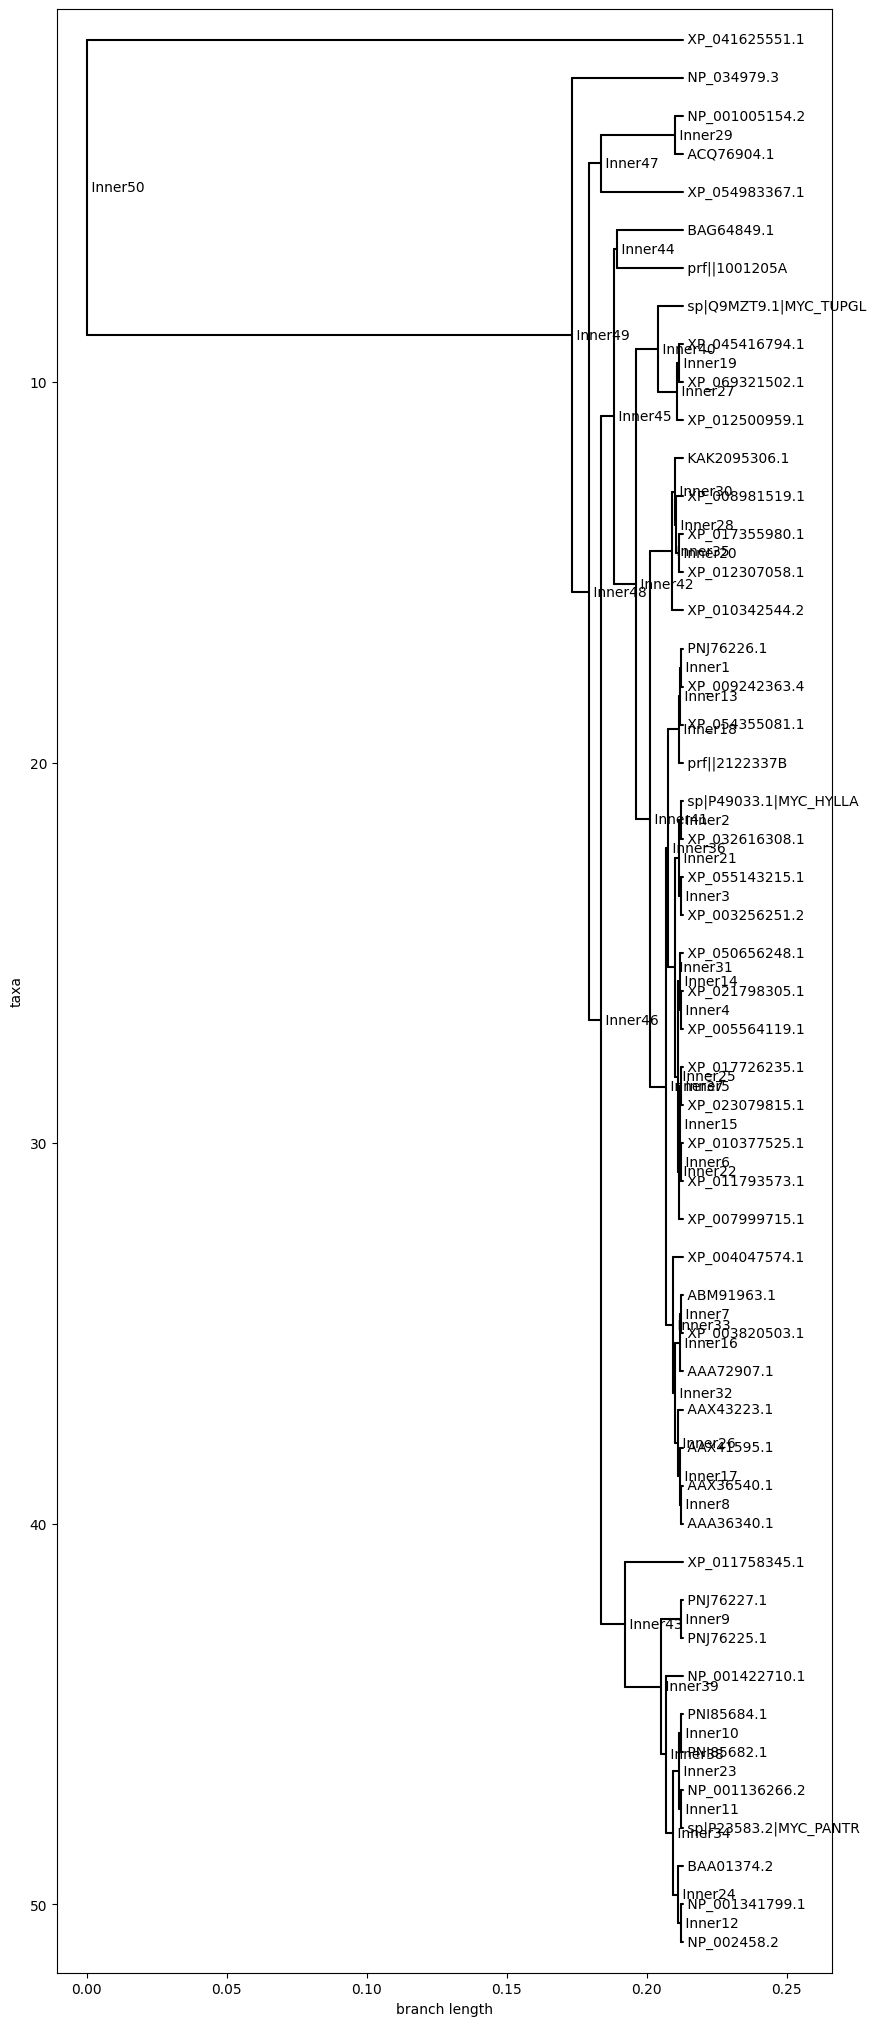

Árvore desenhada. Uma janela gráfica deve ter aparecido.
Feche a janela gráfica para continuar.

Árvore Filogenética (Formato ASCII - terminal):
  ___________________________________________________ XP_041625551.1
 |
 |                                          _________ NP_034979.3
 |                                         |
 |                                         |        , NP_001005154.2
 |                                         |  ______|
 |                                         |,|      | ACQ76904.1
_|                                         |||
 |                                         |||_______ XP_054983367.1
 |                                         ||
 |                                         ||   ____ BAG64849.1
 |                                         ||  |
 |                                         ||  |____ prf||1001205A
 |                                         ||  |
 |                                         ||  |   _ sp|Q9MZT9.1|MYC_TUPGL
 |________________

In [10]:
input_alignment_filepath = "clustal_alignment.aln"

# Formato do ficheiro de alinhamento de entrada.
# Ex: 'fasta', 'phylip', 'clustal', 'nexus', 'emboss', etc.
input_alignment_format = "clustal"

# Método para calcular distâncias entre sequências alinhadas.
# 'identity' (fração de diferenças) ou nome de uma matriz de substituição (ex: 'blosum62', 'pam250')
distance_calculation_method = "identity"
# Se as suas sequências forem de PROTEÍNA, 'blosum62' é geralmente mais adequado:
# distance_calculation_method = "blosum62"


# Método para construir a árvore a partir da matriz de distâncias.
# 'upgma' ou 'nj' (Neighbor Joining)
tree_construction_method = "upgma"
# Neighbor Joining é frequentemente preferível a UPGMA:
# tree_construction_method = "nj"


# Nome do ficheiro para salvar a árvore no formato Newick
output_tree_filename = "phylogenetic_tree.nwk"

# --- FIM DAS CONFIGURAÇÕES ---


def read_alignment_file(filepath, format):
    """
    Reads an alignment file and returns the Alignment object.
    """
    print(f"A ler o alinhamento do ficheiro: {filepath} (Formato: {format})...")
    try:
        alignment = AlignIO.read(filepath, format)
        print(f"[*] Alinhamento lido com sucesso: {len(alignment)} sequências, comprimento {alignment.get_alignment_length()}.")
        if not alignment:
             print("[!] Aviso: O ficheiro de alinhamento está vazio.", file=sys.stderr)
             return None
        if len(alignment) < 2:
             print("[!] Aviso: São necessárias pelo menos 2 sequências no alinhamento para construir uma árvore filogenética.", file=sys.stderr)
             return None
        if alignment.get_alignment_length() == 0:
             print("[!] Aviso: O alinhamento tem comprimento zero.", file=sys.stderr)
             return None

        return alignment

    except FileNotFoundError:
        print(f"[!] ERRO: Ficheiro de alinhamento não encontrado em {filepath}", file=sys.stderr)
        return None
    except ValueError as e:
         print(f"[!] ERRO ao ler o ficheiro '{filepath}': {e}", file=sys.stderr)
         print(f"    Verifique se o ficheiro está realmente no formato '{format}'.", file=sys.stderr)
         return None
    except Exception as e:
         print(f"[!] ERRO inesperado ao ler o ficheiro de alinhamento: {e}", file=sys.stderr)
         return None


def build_and_draw_tree(alignment, distance_method, tree_method, output_tree_file):
    """
    Calculates distances, builds the tree, draws it, and saves it.
    """
    print("\n--- Construção da Árvore Filogenética ---")
    print(f"Método de Distância: '{distance_method}'")
    print(f"Método de Construção da Árvore: '{tree_method}'")


    # 1. Calcular a Matriz de Distância
    try:
        if distance_method == 'identity':
             calculator = DistanceCalculator('identity')
             print("Calculando a Matriz de Distância (Identidade)...")
        else: # Assume que é um nome de matriz de substituição
             try:
                matrix = substitution_matrices.load(distance_method)
                calculator = DistanceCalculator(matrix)
                print(f"Calculando a Matriz de Distância (Matriz de Substituição: {distance_method})...")
             except Exception as matrix_error:
                 print(f"[!] ERRO ao carregar a matriz de substituição '{distance_method}': {matrix_error}", file=sys.stderr)
                 print("    Cálculo da matriz de distância falhou.", file=sys.stderr)
                 return
        
        dm = calculator.get_distance(alignment)
        print("Matriz de Distância Calculada:")
        print(dm) # Imprime a matriz no terminal
    except Exception as e:
        print(f"[!] ERRO ao calcular a matriz de distância: {e}", file=sys.stderr)
        return


    # 2. Construir a Árvore
    try:
        constructor = DistanceTreeConstructor() # Construtor padrão

        if tree_method == "upgma":
             print(f"\nConstruindo a Árvore Filogenética (Método UPGMA)...")
             tree = constructor.upgma(dm)
        elif tree_method == "nj":
             print(f"\nConstruindo a Árvore Filogenética (Método Neighbor Joining)...")
             tree = constructor.nj(dm)
        else:
             print(f"[!] Método de construção da árvore desconhecido nas configurações: '{tree_method}'. Use 'upgma' ou 'nj'.", file=sys.stderr)
             return

        print("Árvore construída com sucesso.")
    except Exception as e:
        print(f"[!] ERRO ao construir a árvore: {e}", file=sys.stderr)
        return

    # 3. Desenhar a Árvore (Gráfica)
    try:
        print("\nTentando desenhar a árvore graficamente (requer matplotlib)...")
        # Cria a figura e os eixos
        # O tamanho da figura pode ser ajustado
        fig = plt.figure(figsize=(10, max(5, len(alignment)*0.5))) # Ajusta altura baseada no nº de seqs
        axes = fig.add_subplot(1, 1, 1)

        # Desenha a árvore nos eixos criados
        Phylo.draw(tree, axes=axes)

        print("Árvore desenhada. Uma janela gráfica deve ter aparecido.")
        # Mostra a janela gráfica. Em muitos editores, esta linha é necessária.
        plt.show()
        print("Feche a janela gráfica para continuar.")

    except ImportError:
        print("[!] Ignorando o desenho gráfico: A biblioteca 'matplotlib' não está instalada.")
        print("    Para desenhar a árvore graficamente, instale-a com: pip install matplotlib")
    except Exception as e:
         print(f"[!] ERRO ao desenhar a árvore graficamente: {e}", file=sys.stderr)


    # 4. Desenhar a Árvore (ASCII no Terminal)
    print("\nÁrvore Filogenética (Formato ASCII - terminal):")
    try:
        Phylo.draw_ascii(tree)
    except Exception as e:
        print(f"[!] ERRO ao desenhar a árvore em ASCII: {e}", file=sys.stderr)

    # 5. Salvar a árvore num ficheiro (formato Newick)
    print(f"\nSalvando a árvore no formato Newick em '{output_tree_file}'...")
    try:
        Phylo.write(tree, output_tree_file, "newick")
        print(f"[*] Árvore salva com sucesso em '{output_tree_file}'.")
        print("    Este ficheiro pode ser aberto em visualizadores de árvores filogenéticas (ex: FigTree, iTOL).")
    except Exception as e:
         print(f"[!] ERRO ao salvar a árvore: {e}", file=sys.stderr)


# --- Execução Principal ---
def main():
    # As configurações são lidas das variáveis no início do script
    print("--- A iniciar script de construção de árvore ---")

    # Lê o alinhamento do ficheiro especificado nas configurações
    alignment = read_alignment_file(input_alignment_filepath, input_alignment_format)

    # Se a leitura foi bem sucedida, constrói e desenha/salva a árvore
    if alignment:
        build_and_draw_tree(alignment, distance_calculation_method, tree_construction_method, output_tree_filename)
    else:
        print("\n[!] Script terminado devido a erro na leitura do alinhamento.", file=sys.stderr)
        # Não saímos com sys.exit(1) se estamos a correr no editor,
        # para não fechar a consola imediatamente.

if __name__ == "__main__":
    main()
